# **DEEP LEARNING FOR LIVER SEGMENTATION**

# GPU CHECK

In [1]:
import torch

# Set device to GPU if available, else fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Using device:", device)
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")


Using device: cuda
GPU Name: Tesla T4


# IMPORTS

In [2]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import glob

import nibabel as nib
import cv2
import imageio
from tqdm.notebook import tqdm
from ipywidgets import *
from PIL import Image


In [3]:
!python --version

Python 3.11.11


In [4]:
#!pip install torch==1.12.1 torchvision==0.13.1 torchaudio==0.12.1 --index-url https://download.pytorch.org/whl/cpu
#!pip install fastai==2.7.12
!pip install medpy
#!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.3/156.3 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for medpy: filename=MedPy-0.5.2-py3-none-any.whl size=224709 sha256=0c8b29ff64693bb71381a6325d6dab69ce31480d1e4b09d3b3984a66c28970cb
  Stored in directory: /root/.cache/pip/wheels/d4/33/ed/aaac5a347fb8d41679ca515b8f5c49dfdf49be15bdbb9a905d
Successfully built medpy


In [5]:
#!pip uninstall torch torchvision torchaudio -y

#!pip cache purge

#!pip install torch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2 --index-url https://download.pytorch.org/whl/cpu


In [6]:
import torch
import torchvision
print(torch.__version__)       # Should be 2.0.1
print(torchvision.__version__)  # Should be 0.15.2


2.5.1+cu124
0.20.1+cu124


In [7]:
from sklearn.metrics import f1_score, accuracy_score, recall_score
from medpy.metric.binary import hd95, hd, assd
import torch
import os
from fastai.vision.augment import aug_transforms
from fastai.vision.learner import cnn_learner
from fastai.basics import *
from fastai.vision.all import *
from fastai.data.transforms import *

In [8]:
# Create a meta file for nii files processing

file_list = []
for dirname, _, filenames in os.walk('../input/liver-tumor-segmentation'):
    for filename in filenames:
#         print(os.path.join(dirname, filename))
        file_list.append((dirname,filename)) 

for dirname, _, filenames in os.walk('../input/liver-tumor-segmentation-part-2'):
    for filename in filenames:
        file_list.append((dirname,filename)) 

df_files = pd.DataFrame(file_list, columns =['dirname', 'filename']) 
df_files.sort_values(by=['filename'], ascending=True)    

dirname              filename
89       ../input/liver-tumor-segmentation/segmentations    segmentation-0.nii
81       ../input/liver-tumor-segmentation/segmentations    segmentation-1.nii
142      ../input/liver-tumor-segmentation/segmentations   segmentation-10.nii
31       ../input/liver-tumor-segmentation/segmentations  segmentation-100.nii
45       ../input/liver-tumor-segmentation/segmentations  segmentation-101.nii
..                                                   ...                   ...
243  ../input/liver-tumor-segmentation-part-2/volume_pt6         volume-95.nii
222  ../input/liver-tumor-segmentation-part-2/volume_pt6         volume-96.nii
217  ../input/liver-tumor-segmentation-part-2/volume_pt6         volume-97.nii
252  ../input/liver-tumor-segmentation-part-2/volume_pt6         volume-98.nii
231  ../input/liver-tumor-segmentation-part-2/volume_pt6         volume-99.nii

[262 rows x 2 columns]

In [9]:
# Map CT scan and label 

df_files["mask_dirname"] = "" ; df_files["mask_filename"] = ""

for i in range(131):
    ct = f"volume-{i}.nii"
    mask = f"segmentation-{i}.nii"
    
    df_files.loc[df_files['filename'] == ct, 'mask_filename'] = mask
    df_files.loc[df_files['filename'] == ct, 'mask_dirname'] = "../input/liver-tumor-segmentation/segmentations"

# drop segment rows
df_files = df_files[df_files.mask_filename != ''].sort_values(by=['filename']).reset_index(drop=True) 
print(len(df_files))
df_files

131


dirname        filename  \
0           ../input/liver-tumor-segmentation/volume_pt1    volume-0.nii   
1           ../input/liver-tumor-segmentation/volume_pt1    volume-1.nii   
2           ../input/liver-tumor-segmentation/volume_pt1   volume-10.nii   
3    ../input/liver-tumor-segmentation-part-2/volume_pt6  volume-100.nii   
4    ../input/liver-tumor-segmentation-part-2/volume_pt8  volume-101.nii   
..                                                   ...             ...   
126  ../input/liver-tumor-segmentation-part-2/volume_pt6   volume-95.nii   
127  ../input/liver-tumor-segmentation-part-2/volume_pt6   volume-96.nii   
128  ../input/liver-tumor-segmentation-part-2/volume_pt6   volume-97.nii   
129  ../input/liver-tumor-segmentation-part-2/volume_pt6   volume-98.nii   
130  ../input/liver-tumor-segmentation-part-2/volume_pt6   volume-99.nii   

                                        mask_dirname         mask_filename  
0    ../input/liver-tumor-segmentation/segmentations    segmentation-0.nii  
1    ../input/liver-tumor-segmentation/segmentations    segmentation-1.nii  
2    ../input/liver-tumor-segmentation/segmentations   segmentation-10.nii  
3    ../input/liver-tumor-segmentation/segmentations  segmentation-100.nii  
4    ../input/liver-tumor-segmentation/segmentations  segmentation-101.nii  
..                                               ...                   ...  
126  ../input/liver-tumor-segmentation/segmentations   segmentation-95.nii  
127  ../input/liver-tumor-segmentation/segmentations   segmentation-96.nii  
128  ../input/liver-tumor-segmentation/segmentations   segmentation-97.nii  
129  ../input/liver-tumor-segmentation/segmentations   segmentation-98.nii  
130  ../input/liver-tumor-segmentation/segmentations   segmentation-99.nii  

[131 rows x 4 columns]

In [10]:
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

In [11]:
# Read sample
sample = 0
sample_ct   = read_nii(df_files.loc[sample,'dirname']+"/"+df_files.loc[sample,'filename'])
sample_mask  = read_nii(df_files.loc[sample,'mask_dirname']+"/"+df_files.loc[sample,'mask_filename'])
sample_ct.shape, sample_mask.shape

((512, 512, 75), (512, 512, 75))

In [12]:
print(np.amin(sample_ct), np.amax(sample_ct))
print(np.amin(sample_mask), np.amax(sample_mask))

-3024.0 1410.0
0.0 2.0


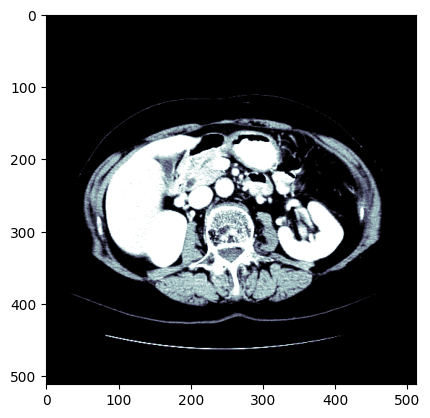

In [13]:
# Preprocess the nii file 
# Source https://docs.fast.ai/medical.imaging

dicom_windows = types.SimpleNamespace(
    brain=(80,40),
    subdural=(254,100),
    stroke=(8,32),
    brain_bone=(2800,600),
    brain_soft=(375,40),
    lungs=(1500,-600),
    mediastinum=(350,50),
    abdomen_soft=(400,50),
    liver=(150,30),
    spine_soft=(250,50),
    spine_bone=(1800,400),
    custom = (200,60)
)

@patch
def windowed(self:Tensor, w, l):
    px = self.clone()
    px_min = l - w//2
    px_max = l + w//2
    px[px<px_min] = px_min
    px[px>px_max] = px_max
    return (px-px_min) / (px_max-px_min)

plt.imshow(tensor(sample_ct[...,50].astype(np.float32)).windowed(*dicom_windows.liver), cmap=plt.cm.bone);

In [14]:
def plot_sample(array_list, color_map = 'nipy_spectral'):
    '''
    Plots and a slice with all available annotations
    '''
    fig = plt.figure(figsize=(18,15))

    plt.subplot(1,4,1)
    plt.imshow(array_list[0], cmap='bone')
    plt.title('Original Image')
    
    plt.subplot(1,4,2)
    plt.imshow(tensor(array_list[0].astype(np.float32)).windowed(*dicom_windows.liver), cmap='bone');
    plt.title('Windowed Image')
    
    plt.subplot(1,4,3)
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Mask')
    
    plt.subplot(1,4,4)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Liver & Mask')


    plt.show()

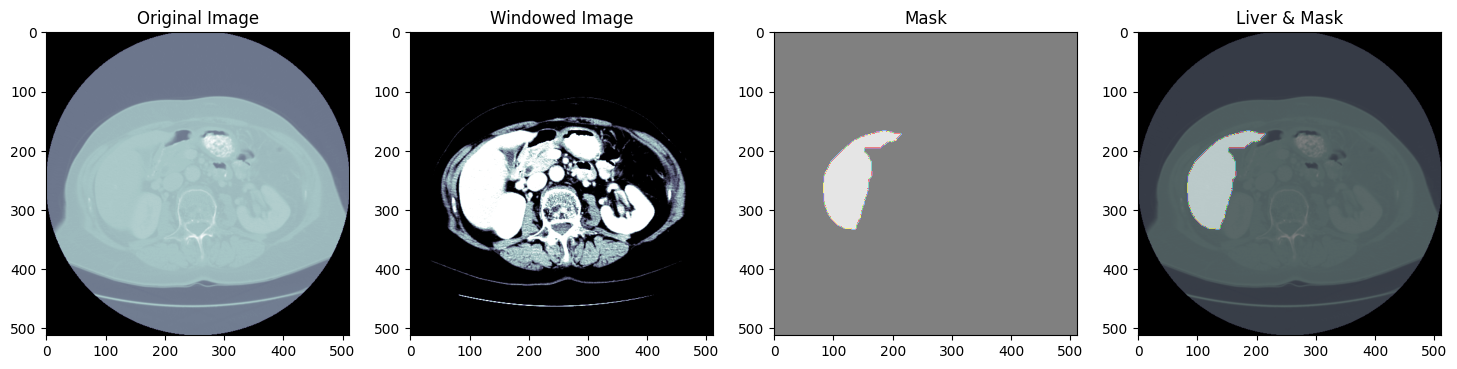

In [15]:
sample=50
sample_slice = tensor(sample_ct[...,sample].astype(np.float32))

plot_sample([sample_ct[...,sample], sample_mask[...,sample]])

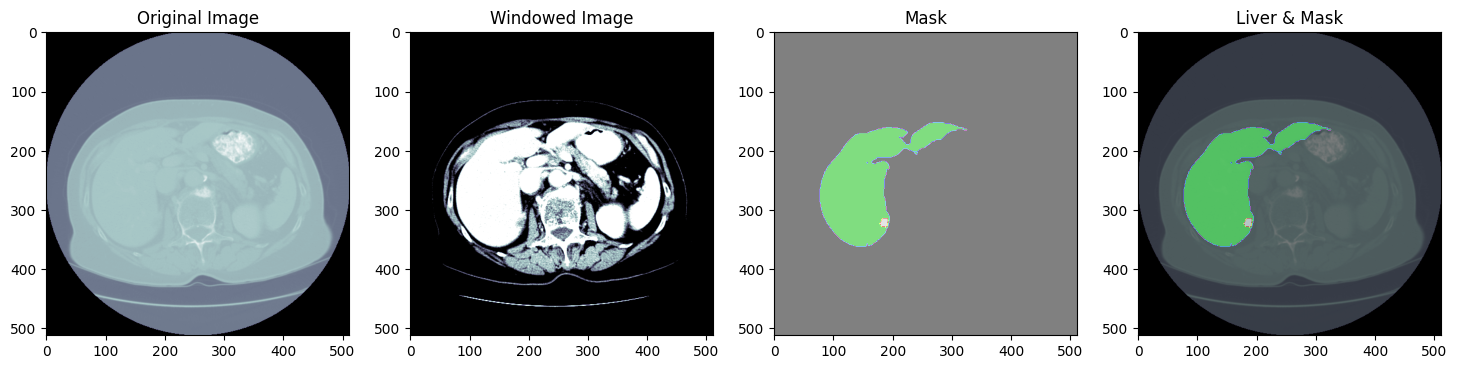

In [16]:
sample=56
sample_slice = tensor(sample_ct[...,sample].astype(np.float32))

plot_sample([sample_ct[...,sample], sample_mask[...,sample]])

In [17]:
# Check the mask values
mask = Image.fromarray(sample_mask[...,sample].astype('uint8'), mode="L")
unique, counts = np.unique(mask, return_counts=True)
print( np.array((unique, counts)).T)

[[     0 241159]
 [     1  20812]
 [     2    173]]


<Axes: >

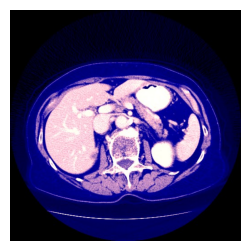

In [18]:
# Preprocessing functions
# Source https://docs.fast.ai/medical.imaging

class TensorCTScan(TensorImageBW): _show_args = {'cmap':'bone'}

@patch
def freqhist_bins(self:Tensor, n_bins=100):
    "A function to split the range of pixel values into groups, such that each group has around the same number of pixels"
    imsd = self.view(-1).sort()[0]
    t = torch.cat([tensor([0.001]),
                   torch.arange(n_bins).float()/n_bins+(1/2/n_bins),
                   tensor([0.999])])
    t = (len(imsd)*t).long()
    return imsd[t].unique()
    
@patch
def hist_scaled(self:Tensor, brks=None):
    "Scales a tensor using `freqhist_bins` to values between 0 and 1"
    if self.device.type=='cuda': return self.hist_scaled_pt(brks)
    if brks is None: brks = self.freqhist_bins()
    ys = np.linspace(0., 1., len(brks))
    x = self.numpy().flatten()
    x = np.interp(x, brks.numpy(), ys)
    return tensor(x).reshape(self.shape).clamp(0.,1.)
    
    
@patch
def to_nchan(x:Tensor, wins, bins=None):
    res = [x.windowed(*win) for win in wins]
    if not isinstance(bins,int) or bins!=0: res.append(x.hist_scaled(bins).clamp(0,1))
    dim = [0,1][x.dim()==3]
    return TensorCTScan(torch.stack(res, dim=dim))

@patch
def save_jpg(x:(Tensor), path, wins, bins=None, quality=90):
    fn = Path(path).with_suffix('.jpg')
    x = (x.to_nchan(wins, bins)*255).byte()
    im = Image.fromarray(x.permute(1,2,0).numpy(), mode=['RGB','CMYK'][x.shape[0]==4])
    im.save(fn, quality=quality)

_,axs=subplots(1,1)

sample_slice.save_jpg('test.jpg', [dicom_windows.liver,dicom_windows.custom])
show_image(Image.open('test.jpg'), ax=axs[0])


In [19]:
# Make custom JPG files for Unet training
# Total number of 131 nii files contains 67072 slices 

GENERATE_JPG_FILES = True   # warning: generation takes ~ 1h

if (GENERATE_JPG_FILES) :
    
    path = Path(".")

    os.makedirs('train_images',exist_ok=True)
    os.makedirs('train_masks',exist_ok=True)

    for ii in tqdm(range(0,len(df_files),3)): # take 1/3 nii files for training
        curr_ct        = read_nii(df_files.loc[ii,'dirname']+"/"+df_files.loc[ii,'filename'])
        curr_mask      = read_nii(df_files.loc[ii,'mask_dirname']+"/"+df_files.loc[ii,'mask_filename'])
        curr_file_name = str(df_files.loc[ii,'filename']).split('.')[0]
        curr_dim       = curr_ct.shape[2] # 512, 512, curr_dim

        for curr_slice in range(0,curr_dim,2): # export every 2nd slice for training
            data = tensor(curr_ct[...,curr_slice].astype(np.float32))
            mask = Image.fromarray(curr_mask[...,curr_slice].astype('uint8'), mode="L")
            data.save_jpg(f"train_images/{curr_file_name}_slice_{curr_slice}.jpg", [dicom_windows.liver,dicom_windows.custom])
            mask.save(f"train_masks/{curr_file_name}_slice_{curr_slice}_mask.png")
else:
    
    path = Path("../input/liver-segmentation-with-fastai-v2") # read jpg from saved kernel output


  0%|          | 0/44 [00:00<?, ?it/s]

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


# MODEL TRAINING

In [20]:

bs = 16
im_size = 128

codes = np.array(["background","liver","tumor"])
    
def get_x(fname:Path): return fname
def label_func(x): return path/'train_masks'/f'{x.stem}_mask.png'

tfms = [IntToFloatTensor(),Normalize()]

db = DataBlock(blocks=(ImageBlock(),MaskBlock(codes)),  #codes = {"Backround": 0,"Liver": 1,"Tumor": 2}
               batch_tfms=tfms,
               splitter=RandomSplitter(),
               item_tfms=[Resize(im_size)],
               get_items=get_image_files,
               get_y=label_func
              )

ds = db.datasets(source=path/'train_images')

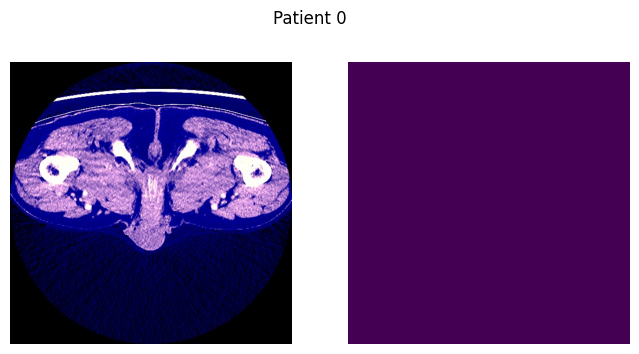

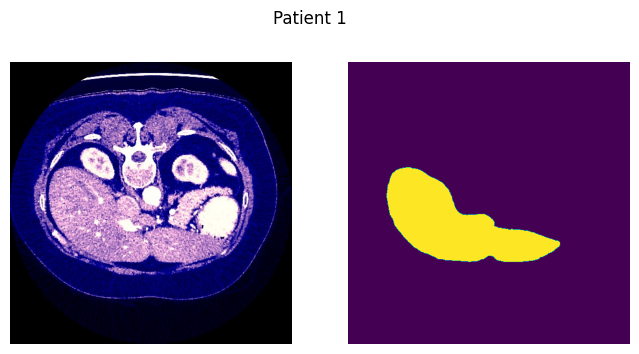

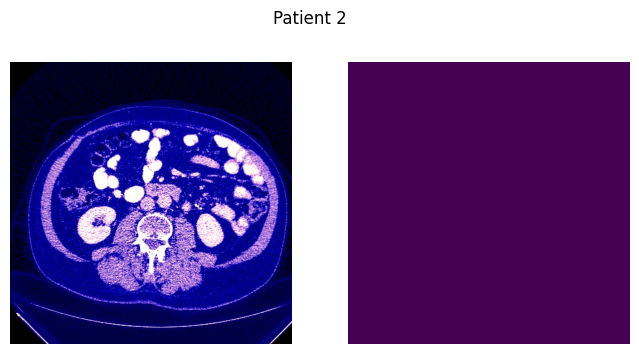

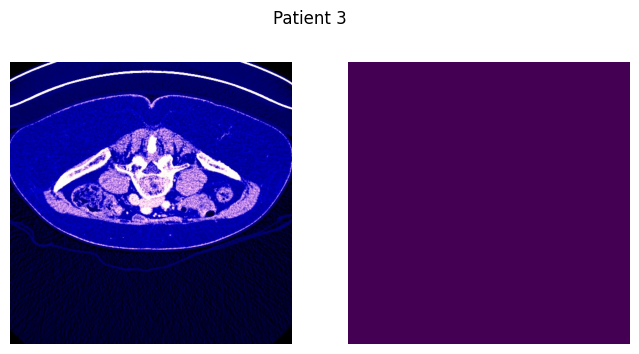

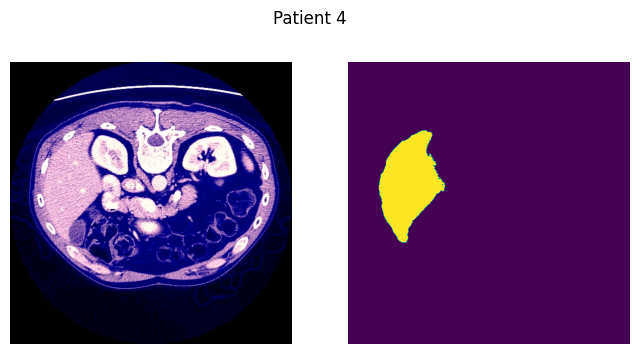

In [21]:
for idx in range(5):
    imgs = [ds[idx][0], ds[idx][1]]
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    for i, ax in enumerate(axs.flatten()):
        ax.axis('off')
        ax.imshow(imgs[i])
    plt.suptitle(f"Patient {idx}")
    plt.show()


In [22]:
unique, counts = np.unique(array(ds[idx][1]), return_counts=True)

print( np.array((unique, counts)).T)


[[     0 247940]
 [     1  14204]]


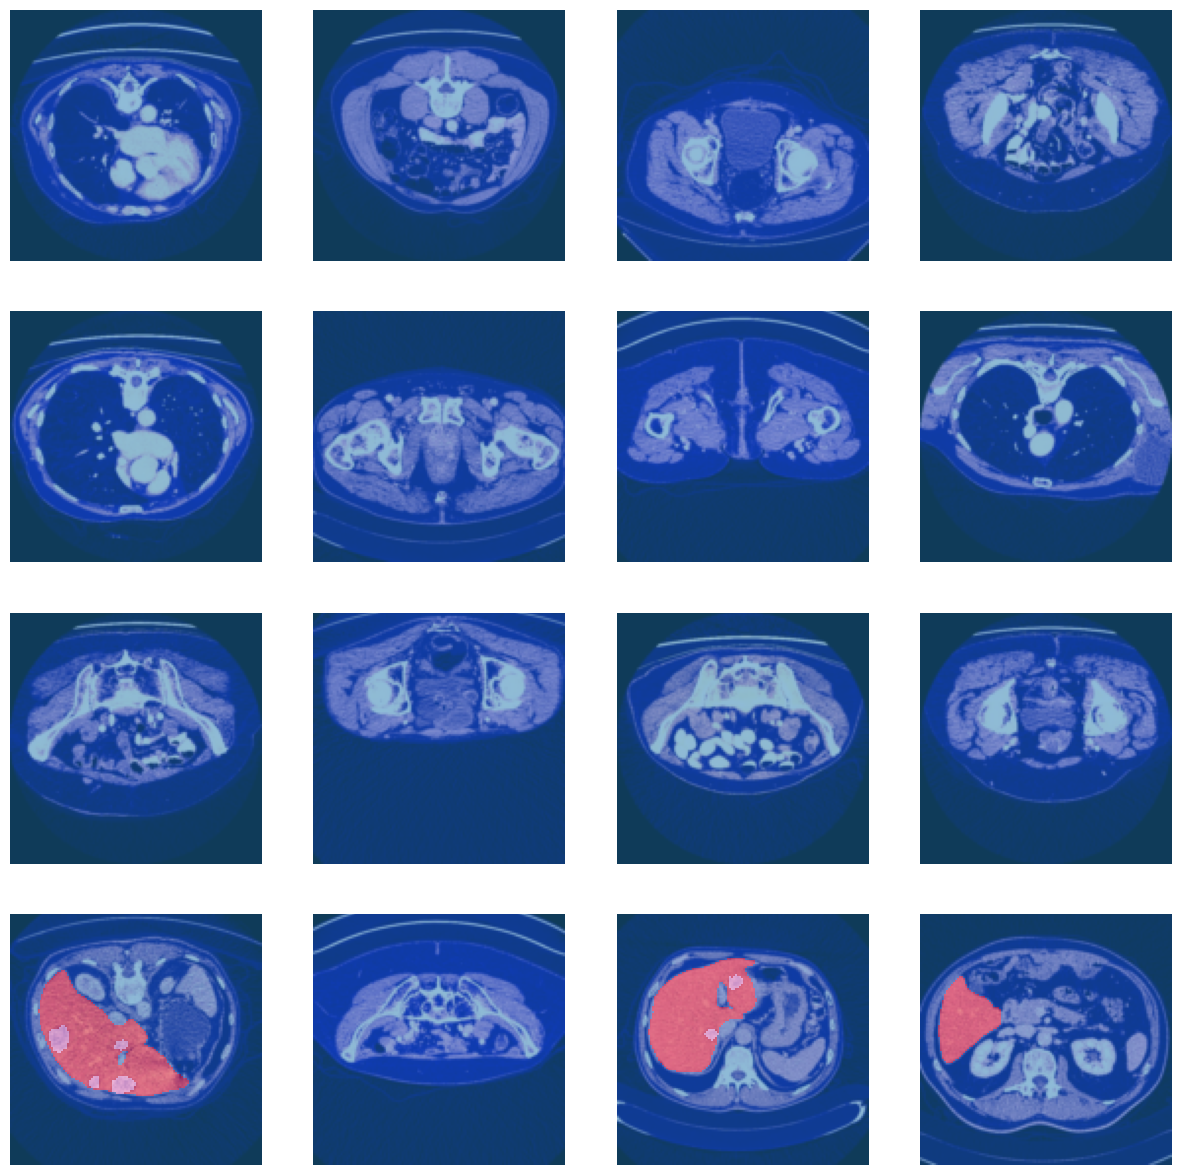

In [23]:
dls = db.dataloaders(path/'train_images',bs = bs) #, num_workers=0
dls.show_batch(max_n=16, nrows=4, ncols=4, figsize=(15, 15))

In [24]:
import warnings
warnings.filterwarnings("ignore")
from fastai.vision.all import *
from fastai.callback.core import Callback
from fastai.callback.tracker import SaveModelCallback
from fastai.learner import Recorder

In [25]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"✅ Using device: {device} -", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU only")

✅ Using device: cuda - Tesla T4


In [26]:
# ✅ Foreground Accuracy Metrics
def foreground_acc(inp, targ, bkg_idx=0, axis=1):
    "Computes non-background accuracy for multiclass segmentation"
    targ = targ.squeeze(1)
    mask = targ != bkg_idx
    return (inp.argmax(dim=axis)[mask] == targ[mask]).float().mean()

def cust_foreground_acc(inp, targ):
    "Custom version that includes background in the metric"
    return foreground_acc(inp=inp, targ=targ, bkg_idx=3, axis=1)  # 3 is a dummy value

In [27]:
from fastai.callback.core import Callback
from fastai.callback.tracker import TrackerCallback
from fastai.callback.progress import ProgressCallback
from fastai.learner import Recorder
from fastai.metrics import Dice

In [28]:
import torch
import torch.nn.functional as F
import numpy as np
import warnings
from fastai.callback.core import Callback

# ✅ Globally silence warnings and FastAI callback errors
warnings.filterwarnings("ignore")
torch.set_printoptions(sci_mode=False)

# ✅ DICE SCORE COMPUTATION FUNCTION
def compute_dice_score(preds, targets, smooth=1e-5, axis=1):
    preds = torch.argmax(preds, dim=axis)
    num_classes = int(torch.max(targets)) + 1

    # One-hot encode predictions and targets
    preds = F.one_hot(preds, num_classes=num_classes)
    targets = F.one_hot(targets.long(), num_classes=num_classes)

    # Reshape to [B, C, D, H, W] or [B, C, H, W]
    if preds.ndim == 5:  # [B, D, H, W, C]
        preds = preds.permute(0, 4, 1, 2, 3).float()
        targets = targets.permute(0, 4, 1, 2, 3).float()
        dims = (2, 3, 4)
    elif preds.ndim == 4:  # [B, H, W, C]
        preds = preds.permute(0, 3, 1, 2).float()
        targets = targets.permute(0, 3, 1, 2).float()
        dims = (2, 3)
    else:
        return torch.tensor(0.0)

    intersection = (preds * targets).sum(dim=dims)
    union = preds.sum(dim=dims) + targets.sum(dim=dims)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.mean(dim=1).mean().item()


# ✅ CALLBACK TO TRACK DICE AND LOSS PER EPOCH (fully silent)
class ExtendedMetrics(Callback):
    def before_fit(self):
        self.train_losses, self.val_losses = [], []
        self.train_dice, self.val_dice = [], []
        self.train_preds, self.train_targets = [], []
        self.preds, self.targets = [], []
        self.epoch = 1

    def after_batch(self):
        try:
            if self.learn.pred is None:
                return

            pred = self.learn.pred.detach().cpu()
            target = None

            if hasattr(self.learn, "y") and self.learn.y is not None:
                target = self.learn.y.detach().cpu()
            elif self.yb is not None and isinstance(self.yb, (list, tuple)) and self.yb[0] is not None:
                target = self.yb[0].detach().cpu()

            if target is None:
                return

            if self.learn.training:
                self.train_preds.append(pred)
                self.train_targets.append(target)
            else:
                self.preds.append(pred)
                self.targets.append(target)
        except Exception:
            pass  # Fully silent error handling

    def after_epoch(self):
        train_loss = self._to_float(getattr(self, 'smooth_loss', None))

        val_loss = None
        if hasattr(self.learn, 'recorder') and hasattr(self.learn.recorder, 'values') and self.learn.recorder.values:
            for v in reversed(self.learn.recorder.values):
                if v and v[0] is not None:
                    val_loss = self._to_float(v[0])
                    break
        else:
            val_loss = np.nan

        train_dice = None
        if self.train_preds and self.train_targets:
            try:
                tp = torch.cat(self.train_preds)
                tt = torch.cat(self.train_targets)
                train_dice = compute_dice_score(tp, tt)
            except:
                train_dice = np.nan

        val_dice = None
        if self.preds and self.targets:
            try:
                vp = torch.cat(self.preds)
                vt = torch.cat(self.targets)
                val_dice = compute_dice_score(vp, vt)
            except:
                val_dice = np.nan

        self.train_losses.append(self._to_safe(train_loss))
        self.val_losses.append(self._to_safe(val_loss))
        self.train_dice.append(self._to_safe(train_dice))
        self.val_dice.append(self._to_safe(val_dice))

        self.train_preds.clear()
        self.train_targets.clear()
        self.preds.clear()
        self.targets.clear()
        
        print(f"[Epoch {self.epoch}] "
          f"Train Loss: {self._fmt(train_loss)} | "
          f"Val Loss: {self._fmt(val_loss)} | "
          f"Train Dice: {self._fmt(train_dice)} | "
          f"Val Dice: {self._fmt(val_dice)}")
        self.epoch += 1

    def after_fit(self):
        np.save('train_losses.npy', np.array(self.train_losses))
        np.save('test_losses.npy', np.array(self.val_losses))
        np.save('train_dice_score.npy', np.array(self.train_dice))
        np.save('test_dice_score.npy', np.array(self.val_dice))

    def _to_float(self, x):
        try:
            if isinstance(x, torch.Tensor): x = x.detach().cpu().item()
            return float(x)
        except:
            return np.nan

    def _to_safe(self, x):
        return float(x) if x is not None and not np.isnan(x) and x <= 1.0 else np.nan

    def _fmt(self, x):
        return f"{float(x):.4f}" if x is not None and not np.isnan(x) else "nan"


In [29]:
learn = unet_learner(
    dls,
    resnet34,
    loss_func=CrossEntropyLossFlat(axis=1),
    metrics=[foreground_acc, cust_foreground_acc],
    cbs=[ExtendedMetrics()]
).to_fp32()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 186MB/s]


In [30]:
learn.model = learn.model.to(device)

In [31]:
from fastai.callback.tracker import EarlyStoppingCallback, SaveModelCallback

learn.fine_tune(
    8,
    wd=0.1,
    cbs=[ SaveModelCallback ]
)

[Epoch 1] Train Loss: 0.0153 | Val Loss: nan | Train Dice: 0.9023 | Val Dice: 0.8587
Better model found at epoch 0 with valid_loss value: 0.019840482622385025.


[Epoch 1] Train Loss: 0.0053 | Val Loss: nan | Train Dice: 0.9542 | Val Dice: 0.9623
Better model found at epoch 0 with valid_loss value: 0.005725451745092869.
[Epoch 2] Train Loss: 0.0057 | Val Loss: 0.0053 | Train Dice: 0.9591 | Val Dice: 0.9601
Better model found at epoch 1 with valid_loss value: 0.00506924232468009.
[Epoch 3] Train Loss: 0.0042 | Val Loss: 0.0057 | Train Dice: 0.9659 | Val Dice: 0.9727
Better model found at epoch 2 with valid_loss value: 0.00472899479791522.
[Epoch 4] Train Loss: 0.0036 | Val Loss: 0.0042 | Train Dice: 0.9715 | Val Dice: 0.9746
Better model found at epoch 3 with valid_loss value: 0.0037402771413326263.
[Epoch 5] Train Loss: 0.0029 | Val Loss: 0.0036 | Train Dice: 0.9764 | Val Dice: 0.9788
Better model found at epoch 4 with valid_loss value: 0.003134167520329356.
[Epoch 6] Train Loss: 0.0025 | Val Loss: 0.0029 | Train Dice: 0.9809 | Val Dice: 0.9814
Better model found at epoch 5 with valid_loss value: 0.0027754337061196566.
[Epoch 7] Train Loss: 0.0

In [32]:
import numpy as np

print("Train Losses:", np.load('train_losses.npy'))
print("Val Losses:", np.load('test_losses.npy'))
print("Train Dice:", np.load('train_dice_score.npy'))
print("Val Dice:", np.load('test_dice_score.npy'))


Train Losses: [0.00525892 0.00572926 0.00415856 0.00362013 0.00288103 0.00250323
 0.00197941 0.00197946]
Val Losses: [       nan 0.00525892 0.00572926 0.00415856 0.00362013 0.00288103
 0.00250323 0.00197941]
Train Dice: [0.95421499 0.95905119 0.96587813 0.97150129 0.97639453 0.98090285
 0.98394179 0.98503131]
Val Dice: [0.96225041 0.96010816 0.97274667 0.97455287 0.9788363  0.98142302
 0.98204249 0.981758  ]


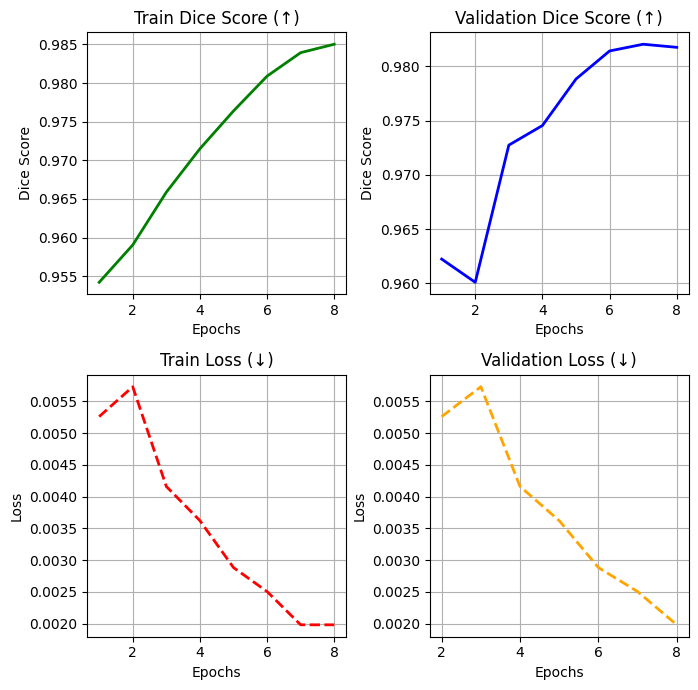

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Load metric arrays
train_losses = np.load('train_losses.npy')
val_losses = np.load('test_losses.npy')
train_dice = np.load('train_dice_score.npy')
val_dice = np.load('test_dice_score.npy')

# Epochs for x-axis
epochs = np.arange(1, len(train_losses) + 1)

# Plot in 2x2 grid
plt.figure(figsize=(7, 7))

# 1. Train Dice
plt.subplot(2, 2, 1)
plt.plot(epochs, train_dice, color='green', linewidth=2)
plt.title('Train Dice Score (↑)')
plt.xlabel('Epochs')
plt.ylabel('Dice Score')
plt.grid(True)

# 2. Val Dice
plt.subplot(2, 2, 2)
plt.plot(epochs, val_dice, color='blue', linewidth=2)
plt.title('Validation Dice Score (↑)')
plt.xlabel('Epochs')
plt.ylabel('Dice Score')
plt.grid(True)

# 3. Train Loss
plt.subplot(2, 2, 3)
plt.plot(epochs, train_losses, color='red', linestyle='--', linewidth=2)
plt.title('Train Loss (↓)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)

# 4. Val Loss
plt.subplot(2, 2, 4)
plt.plot(epochs, val_losses, color='orange', linestyle='--', linewidth=2)
plt.title('Validation Loss (↓)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.show()


[Epoch 1] Train Loss: 0.0020 | Val Loss: nan | Train Dice: nan | Val Dice: 0.9853


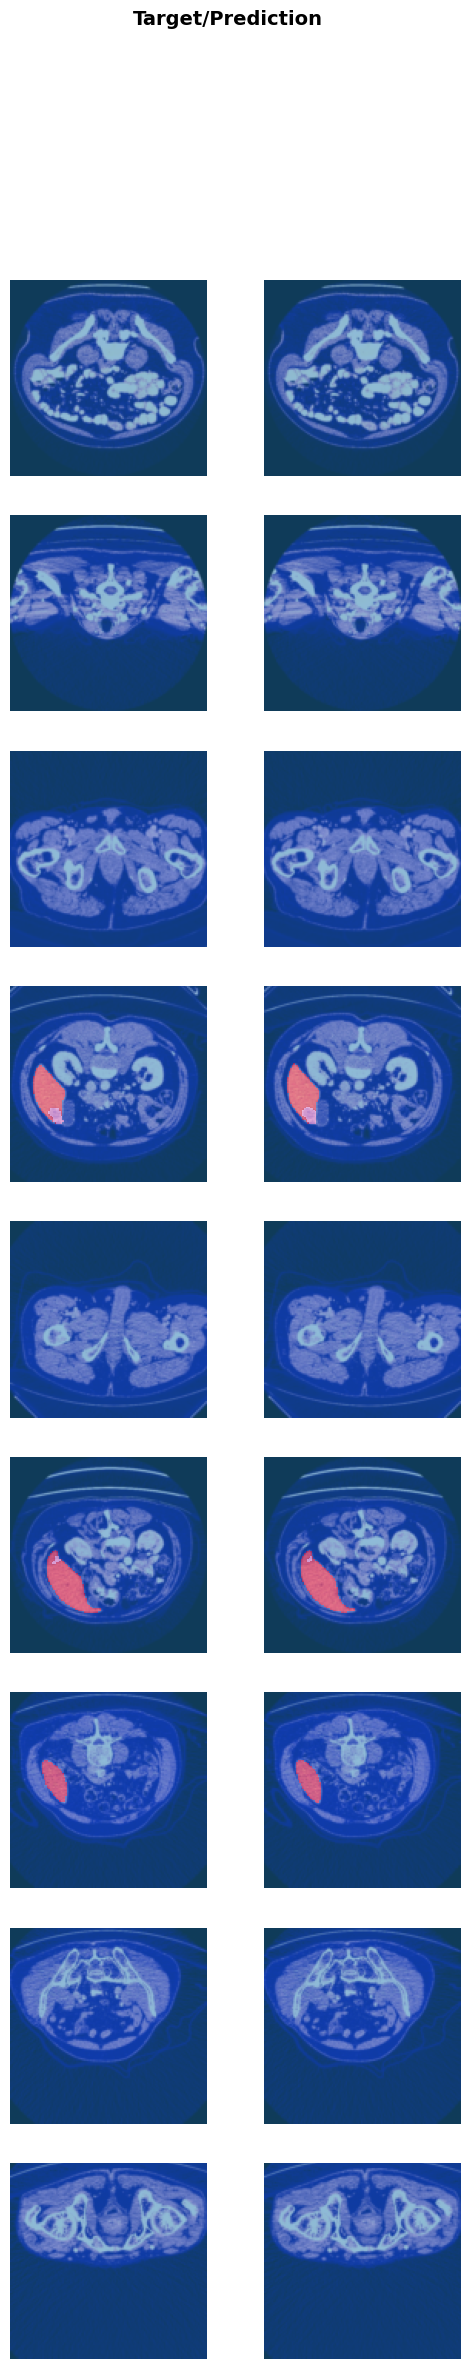

In [34]:
learn.show_results()

In [35]:
# Save the model
learn.export('sdp_best_seg_model.pkl')
torch.save(learn.model.state_dict(), 'sdp_seg_model_state_dict.pth')

In [36]:
learn.export(path/f'Liver_segmentation1')

# TESTING MODEL

In [37]:
# Load saved model
if (GENERATE_JPG_FILES) :
    
    tfms = [Resize(im_size), IntToFloatTensor(),Normalize()]
    learn0               = load_learner(path/f'Liver_segmentation1',cpu=False )
    learn0.dls.transform = tfms

In [38]:
def nii_tfm(fn,wins): 

    test_nii  = read_nii(fn)
    curr_dim  = test_nii.shape[2] # 512, 512, curr_dim
    slices = []
    
    for curr_slice in range(curr_dim):
        data = tensor(test_nii[...,curr_slice].astype(np.float32))
        data = (data.to_nchan(wins)*255).byte()
        slices.append(TensorImage(data))
                      
    return slices 

(512, 512, 908)


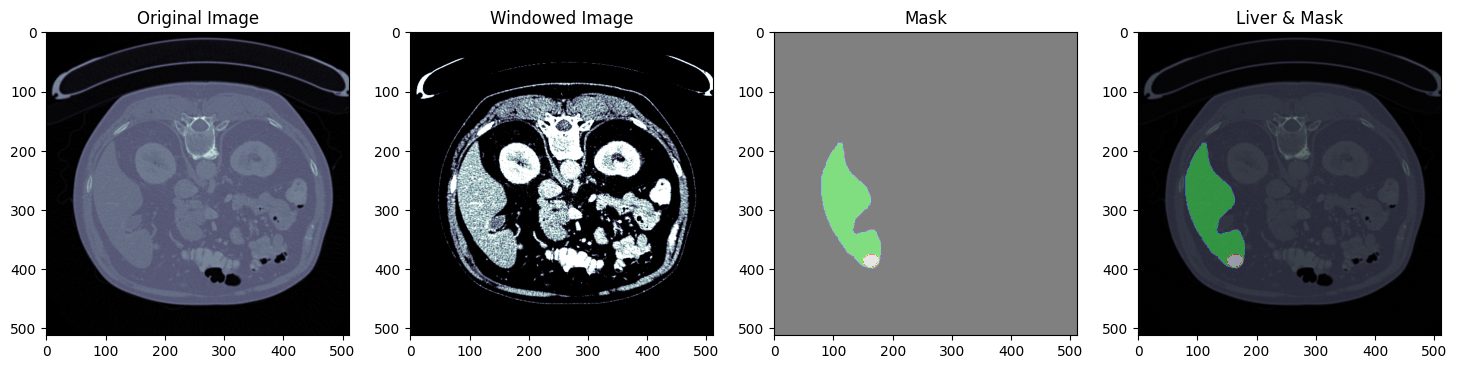

In [39]:
tst = 20

test_nii   = read_nii(df_files.loc[tst,'dirname']+"/"+df_files.loc[tst,'filename'])
test_mask  = read_nii(df_files.loc[tst,'mask_dirname']+"/"+df_files.loc[tst,'mask_filename'])
print(test_nii.shape)

test_slice_idx = 500

sample_slice = tensor(test_nii[...,test_slice_idx].astype(np.float32))

plot_sample([test_nii[...,test_slice_idx], test_mask[...,test_slice_idx]])

In [40]:
# Prepare a nii test file for prediction 

test_files = nii_tfm(df_files.loc[tst,'dirname']+"/"+df_files.loc[tst,'filename'],[dicom_windows.liver, dicom_windows.custom])
print("Number of test slices: ",len(test_files))

Number of test slices:  908


<Axes: >

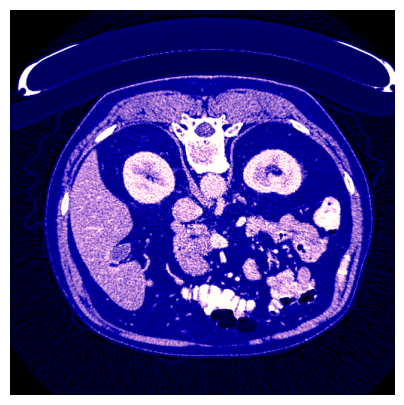

In [41]:
# Check an input for a test file
show_image(test_files[test_slice_idx])

In [42]:
import warnings
warnings.filterwarnings("ignore")


# PREDICTION

[Epoch 1] Train Loss: 0.0020 | Val Loss: nan | Train Dice: nan | Val Dice: nan


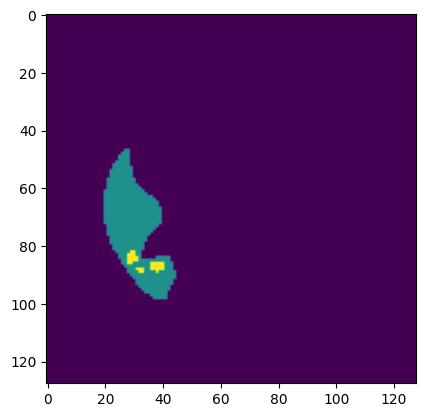

In [43]:
# Get predictions for a Test file
test_dl = learn0.dls.test_dl(test_files)
preds, y = learn0.get_preds(dl=test_dl)

predicted_mask = np.argmax(preds, axis=1)
plt.imshow(predicted_mask[test_slice_idx])

In [44]:
a=np.array(predicted_mask[test_slice_idx])
np.amin(a),np.amax(a),

(0, 2)

 # Metrics

In [45]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from medpy.metric.binary import hd95
import numpy as np
import contextlib, sys, os

# Suppress verbose FastAI outputs
@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, 'w') as fnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = fnull
        sys.stderr = fnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

# Get model predictions silently
with suppress_output():
    preds, targs = learn.get_preds(dl=dls.valid)

preds_bin = (preds.argmax(dim=1)).int()
targs_bin = targs.squeeze(1).int()

# Flatten for classification metrics
y_pred_flat = preds_bin.numpy().flatten()
y_true_flat = targs_bin.numpy().flatten()

# Compute classification metrics
accuracy = accuracy_score(y_true_flat, y_pred_flat) * 100
precision = precision_score(y_true_flat, y_pred_flat, average='weighted') * 100
recall = recall_score(y_true_flat, y_pred_flat, average='weighted') * 100
f1 = f1_score(y_true_flat, y_pred_flat, average='weighted') * 100

# Hausdorff (95%) on the first valid sample only
hausdorff_95 = float('nan')
for i in range(len(preds_bin)):
    p = preds_bin[i].numpy()
    t = targs_bin[i].numpy()
    if np.any(p) and np.any(t):
        hausdorff_95 = hd95(p, t)
        break

# Final Clean Output
print(f"Accuracy:        {accuracy:.2f}%")
print(f"Precision:       {precision:.2f}%")
print(f"Recall:          {recall:.2f}%")
print(f"F1 Score:        {f1:.2f}%")
if not np.isnan(hausdorff_95):
    print(f"Hausdorff (95):  {hausdorff_95:.2f}")
else:
    print(f"Hausdorff (95):  Skipped (no valid prediction-mask pair)")
print(f"Best Dice:       {max(val_dice) * 100:.2f}%")


Accuracy:        99.89%
Precision:       99.89%
Recall:          99.89%
F1 Score:        99.89%
Hausdorff (95):  1.00
Best Dice:       98.20%
